<a href="https://colab.research.google.com/github/beatrizpinheiro/Tensor-Flow-Neural-Network/blob/main/Tensor_Flow_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from inspect import stack
import torch, random
import numpy as np
import math
from matplotlib import pyplot as plt

N = 400
NOISE = 10
SPLIT_RATIO = 0.8
BATCH_SIZE = 40
LEARNING_RATE = 0.3

# Datasets and Graphs

In [ ]:
def plotGraph(dataset):
  indexes_negative = (dataset.Y == -1).nonzero()
  indexes_positive = (dataset.Y == 1).nonzero()

  plt.scatter(x = [dataset.X[index][0][0] for index in indexes_positive],
              y = [dataset.X[index][0][1] for index in indexes_positive],
              label = 'y = 1',
              s = 5)

  plt.scatter(x = [dataset.X[index][0][0] for index in indexes_negative],
              y = [dataset.X[index][0][1] for index in indexes_negative],
              label = 'y = -1',
              s = 5)

  plt.legend()
  plt.show()
  return

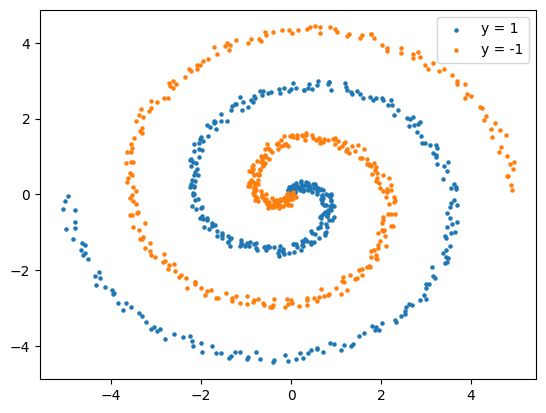

In [ ]:
def genSpiral(delta_t, label):
    r = 5*torch.linspace(0., 1., N+1)[:N]
    t = 0.7*r*math.pi + delta_t
    x0 = r*torch.sin(t)
    x1 = r*torch.cos(t)
    y = label*torch.ones_like(x0)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/70.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class SpiralDataset:
    def __init__(self):
        xp, yp = genSpiral(0, 1) # positive samples
        xn, yn = genSpiral(math.pi, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

dataSpiral = SpiralDataset()
plotGraph(dataSpiral)

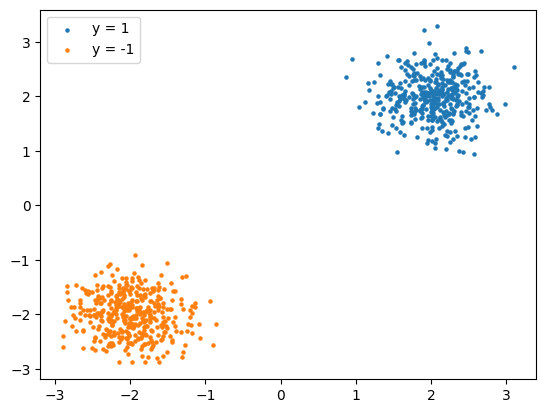

In [ ]:
def genGauss(cx0, cx1, label):
    x = torch.randn(N, 2)
    x = torch.tensor([cx0, cx1]).T + x*(NOISE/25.)
    y = label*torch.ones(N)
    return x, y

class GaussDataset:
    def __init__(self):
        xp, yp = genGauss(2, 2, 1) # positive samples
        xn, yn = genGauss(-2, -2, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

dataGauss = GaussDataset()
plotGraph(dataGauss)

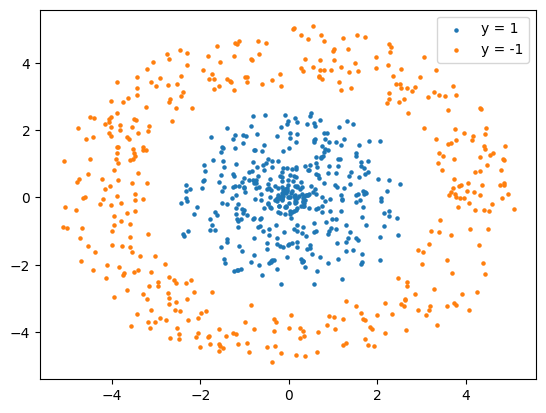

In [ ]:
def genCircle(r_min, r_max, label):
    r = (r_max - r_min)*torch.rand(N) + r_min
    angle = 2*math.pi*torch.rand(N)
    x0 = r*torch.sin(angle)
    x1 = r*torch.cos(angle)
    x = torch.stack((x0, x1), -1)
    sampled_noise = (NOISE/35.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    y = label*torch.ones_like(x0)
    return x, y

class CircleDataset:
    def __init__(self):
        xp, yp = genCircle(0, 2.5, 1) # positive samples
        xn, yn = genCircle(3.5, 5, -1) # negative samples
        self.X = torch.cat((xp, xn))
        self.Y = torch.cat((yp, yn))

dataCircle = CircleDataset()
plotGraph(dataCircle)

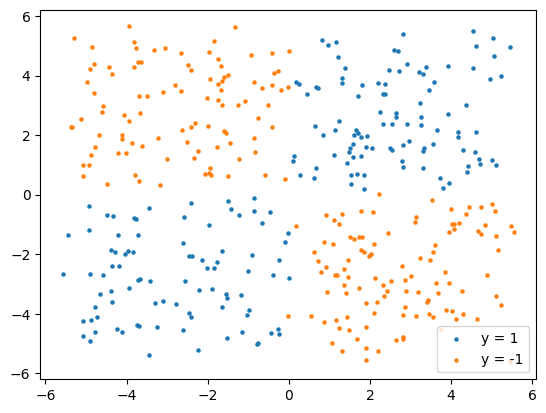

In [ ]:
def genXOR():
    x = 10.*torch.rand(N, 2) - 5.
    y = torch.sign(x[:,0]*x[:,1])
    padding = 0.3
    x += torch.sign(x)*padding
    sampled_noise = (NOISE/25.)*(2*torch.rand(N, 2) - 1.)
    x += sampled_noise
    return x, y

class XORDataset:
    def __init__(self):
        self.X, self.Y = genXOR()

dataXOR = XORDataset()
plotGraph(dataXOR)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def train_test_split(dataset):
    size = len(dataset.X)
    num_elements = int(size * SPLIT_RATIO)
    random_indexes = random.sample(range(size), size)
    train_indexes = random_indexes[:num_elements]
    test_indexes = random_indexes[num_elements:]

    train_x = dataset.X[train_indexes]
    train_y = dataset.Y[train_indexes]
    test_x = dataset.X[test_indexes]
    test_y = dataset.Y[test_indexes]

    dataset_train = TensorDataset(train_x, train_y)
    dataset_test = TensorDataset(test_x, test_y)

    return dataset_train, dataset_test

# Tensor Flow Neural Network

In [ ]:
class Neuron:
    def __init__(self, input):
        self.weights = (torch.rand([input, 1], requires_grad=True))
        self.bias = torch.rand(1, requires_grad=True)

    def inference(self, inp):
        output = torch.sigmoid(torch.matmul(inp, self.weights) + self.bias)
        return (2*output- 1)

class Model:
    def __init__(self, layers):
      self.layers = []
      for layer in layers:
          neurons = [Neuron(num_weights) for num_weights in layer]
          (self.layers).append(neurons)


    def inference(self, inp):
        for layer in self.layers:
          outputs = []
          for neuron in layer:
            outputs.append(neuron.inference(inp))
          inp = torch.cat(outputs, dim=1, out=None)
        return inp

In [ ]:
def get_loss(y, y_hat):
    loss = sum(0.5 * ((y_hat - y)**2))/len(y)
    return loss

def get_accuracy(loss,y,y_hat):
  size = y.numel()
  correct = 0
  correct += torch.sum(((y == 1) & (y_hat >= 0.5)) | ((y == -1) & (y_hat < 0.5))).item()
  correct = (100*correct)/size
  print(f"Accuracy: {correct:.2f}% Loss: {(loss.item()/100)}\n")

In [ ]:
from torch._C import Size

def train_loop(n_epochs, model, dataset_train, dataset_test, lr = LEARNING_RATE):
  losses, losses_test = [], []
  print("--> Training <--\n-------------------------------")
  for epoch in range(n_epochs):
    losses += one_epoch(model, dataset_train, lr, epoch, True)
  print("--> Testing <--\n-------------------------------")
  for epoch in range(n_epochs):
    losses_test += one_epoch(model, dataset_test, lr, epoch, False)

  return losses, losses_test

def one_epoch(model, dataset, lr, epoch, training: bool):
  losses = []
  x,y = dataset.tensors
  dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
  size_dataloader = len(dataloader)
  for idx, (x, y) in enumerate(dataloader):
    y = y.unsqueeze(1)
    y_hat = model.inference(x)
    loss = get_loss(y, y_hat)

    if idx > 0:
      for layer in model.layers:
        for neuron in layer:
          if neuron.weights.grad is not None and torch.any(neuron.weights.grad != 0):
            neuron.weights.grad.zero_()
          if neuron.bias.grad is not None and torch.any(neuron.bias.grad != 0):
            neuron.bias.grad.zero_()

    loss.backward()

    with torch.no_grad():
      for layer in model.layers:
        for neuron in layer:
          neuron.weights -= lr*neuron.weights.grad
          neuron.bias -= lr*neuron.bias.grad

    if not training and idx == size_dataloader-1:
      losses.append(loss.item())

    if training:
      losses.append(loss.item())

    if (epoch == 0 or (epoch+1)%100 == 0) and idx == size_dataloader-1:
      print(f"Epoch {epoch}")
      get_accuracy(loss,y,y_hat)

  return losses

In [ ]:
def plot_graph_losses(losses, num_batch, losses_test, epochs):
  epochs_list = []
  batch_list = list(range(num_batch*epochs))
  for index, i in enumerate(losses_test):
    epochs_list.append((index*num_batch))

  plt.title('Loss Variation')
  plt.plot(batch_list, losses, label='Train')
  plt.plot(epochs_list, losses_test, label='Test')
  plt.ylabel('Loss')
  plt.xlabel('Batchs')
  plt.legend()
  plt.show()

# Circle

--> Training <--
-------------------------------
Epoch 0
Accuracy: 50.00% Loss: 0.004027235507965088

Epoch 99
Accuracy: 90.00% Loss: 0.0007692038267850875

Epoch 199
Accuracy: 95.00% Loss: 0.0003476739302277565

Epoch 299
Accuracy: 95.00% Loss: 0.0002460347302258015

--> Testing <--
-------------------------------
Epoch 0
Accuracy: 97.50% Loss: 0.000311039499938488

Epoch 99
Accuracy: 97.50% Loss: 0.00025628486648201945

Epoch 199
Accuracy: 97.50% Loss: 0.0002370021864771843

Epoch 299
Accuracy: 97.50% Loss: 0.00022183354943990707



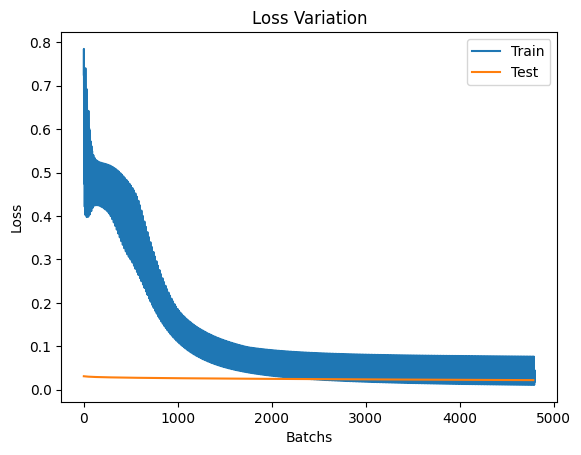

In [ ]:
dataset_train, dataset_test = train_test_split(dataCircle)
model = Model([[2,2,2], [3]])

epochs = 300
losses, losses_test = train_loop(epochs, model, dataset_train, dataset_test, 0.1)

num_batch = (len(dataset_train)/BATCH_SIZE)
plot_graph_losses(losses, int(num_batch), losses_test, epochs)

# Gauss

--> Training <--
-------------------------------
Epoch 0
Accuracy: 100.00% Loss: 0.00022564996033906936

--> Testing <--
-------------------------------
Epoch 0
Accuracy: 100.00% Loss: 0.0001759723573923111



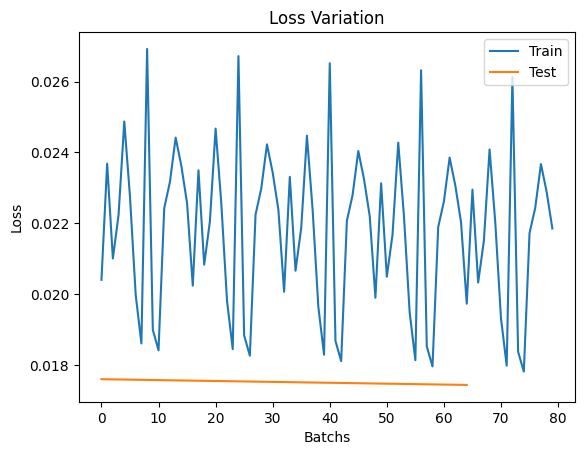

In [ ]:
dataset_train, dataset_test = train_test_split(dataGauss)
model = Model([[2]])

epochs = 5
losses, losses_test = train_loop(epochs, model, dataset_train, dataset_test, 0.001)

num_batchs = (len(dataset_train)/BATCH_SIZE)
plot_graph_losses(losses, int(num_batchs), losses_test, epochs)

# Spiral

In [ ]:
def squared_sets(dataset):
  x,y = dataset.tensors
  new_tensor = torch.cat((x, (x*x)), dim=1)
  return TensorDataset(new_tensor, y)

--> Training <--
-------------------------------
Epoch 0
Accuracy: 50.00% Loss: 0.009433612823486329

Epoch 99
Accuracy: 70.00% Loss: 0.002082355320453644

Epoch 199
Accuracy: 97.50% Loss: 0.0002645940706133842

Epoch 299
Accuracy: 97.50% Loss: 0.0001967441663146019

--> Testing <--
-------------------------------
Epoch 0
Accuracy: 97.50% Loss: 0.0005200964212417603

Epoch 99
Accuracy: 95.00% Loss: 0.0005289553850889206

Epoch 199
Accuracy: 97.50% Loss: 0.0003070254251360893

Epoch 299
Accuracy: 97.50% Loss: 0.00036338530480861664



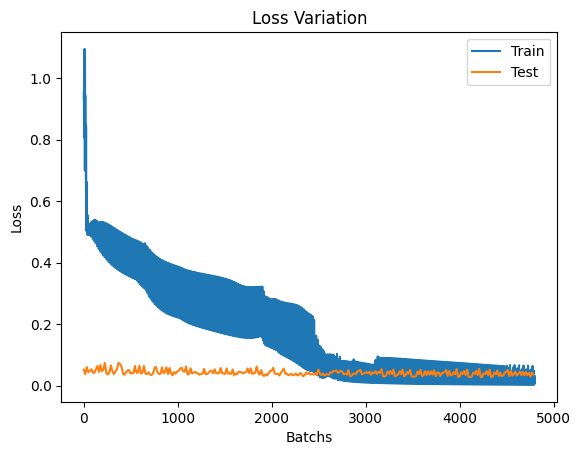

In [ ]:
dataset_train, dataset_test = train_test_split(dataSpiral)
dataset_train_squared = squared_sets(dataset_train)
dataset_test_squared = squared_sets(dataset_test)
model = Model([[4,4,4,4,4,4],[6]])

epochs = 300
losses, losses_test = train_loop(epochs, model, dataset_train_squared, dataset_test_squared)

num_batchs = (len(dataset_train)/BATCH_SIZE)
plot_graph_losses(losses, int(num_batchs), losses_test, epochs)

# XOR

--> Training <--
-------------------------------
Epoch 0
Accuracy: 50.00% Loss: 0.005703643560409546

Epoch 99
Accuracy: 97.50% Loss: 0.0004499117657542229

Epoch 199
Accuracy: 97.50% Loss: 0.00026630153879523275

--> Testing <--
-------------------------------
Epoch 0
Accuracy: 97.50% Loss: 0.00031777489930391313

Epoch 99
Accuracy: 100.00% Loss: 0.00021217260509729386

Epoch 199
Accuracy: 100.00% Loss: 0.00019492145627737046



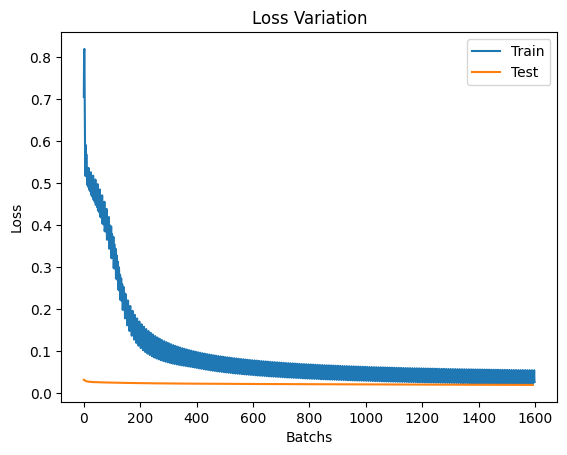

In [ ]:
dataset_train, dataset_test = train_test_split(dataXOR)
model = Model([[2,2,2,2],[4]])

epochs = 200
losses, losses_test = train_loop(epochs, model, dataset_train, dataset_test)

num_batchs = (len(dataset_train)/BATCH_SIZE)
plot_graph_losses(losses, int(num_batchs), losses_test, epochs)